# SortaBin Waste Classifier

## **1.** Import needed libraries

In [2]:
import requests
from pathlib import Path
import zipfile
import torch
import torchvision
import os
import random
from PIL import Image
from torch.utils.data import DataLoader
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm.auto import tqdm

## **2.** Device agnostic code

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **3.** Get and prepare data

In [4]:
# Set data structure
data_dir = Path('data/')
image_dir = data_dir / 'waste_classification'

# Create folder
if image_dir.is_dir():
  print('Folder exists...........')
else:
  print('Creating Folder..........')
  image_dir.mkdir(parents=True, exist_ok=True)

# Get the zip file from github
with open(data_dir/'waste_classification.zip', 'wb') as f:
  request = requests.get('https://github.com/Mahesh1772/Deep_Learning/raw/main/waste_classification.zip')
  print('Downloading zip file........')
  f.write(request.content)

with zipfile.ZipFile(data_dir/'waste_classification.zip', 'r') as zip_ref:
  print('Unzipping file..........')
  zip_ref.extractall(data_dir)

Creating Folder..........
Unzipping file..........


In [5]:
# train and test directories
train_dir = image_dir / 'train'
test_dir = image_dir / 'test'

In [6]:
# Explore directory and data
for dirpath, dirnames, filenames in os.walk(image_dir):
  print(f"There are {len(filenames)} files and {len(dirnames)} directories in {dirpath}")

There are 0 files and 2 directories in data/waste_classification
There are 0 files and 7 directories in data/waste_classification/test
There are 117 files and 0 directories in data/waste_classification/test/paper
There are 107 files and 0 directories in data/waste_classification/test/plastic
There are 92 files and 0 directories in data/waste_classification/test/cardboard
There are 43 files and 0 directories in data/waste_classification/test/trash
There are 90 files and 0 directories in data/waste_classification/test/glass
There are 77 files and 0 directories in data/waste_classification/test/metal
There are 38 files and 0 directories in data/waste_classification/test/compost
There are 0 files and 7 directories in data/waste_classification/train
There are 477 files and 0 directories in data/waste_classification/train/paper
There are 375 files and 0 directories in data/waste_classification/train/plastic
There are 311 files and 0 directories in data/waste_classification/train/cardboard
Th

## **4.** Inspect Random Image (using PIL and NumPy)

Image height: 300
Image width: 400
Image shape: (400, 300)
Image label: cardboard


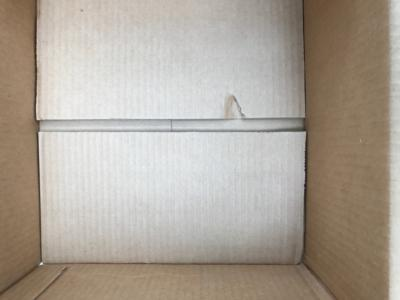

In [7]:
# Random image visualization
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get all image paths in a list
image_path_list = list(image_dir.glob('*/*/*.jpg'))

# Get a random image
random_image_path = random.choice(image_path_list)

img = Image.open(random_image_path)
label = random_image_path.parent.stem

print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
print(f"Image shape: {img.size}")
print(f"Image label: {label}")

img

Image height: 300
Image width: 400
Image shape: (300, 400, 3)
Image label: cardboard


Text(0.5, 1.0, 'cardboard')

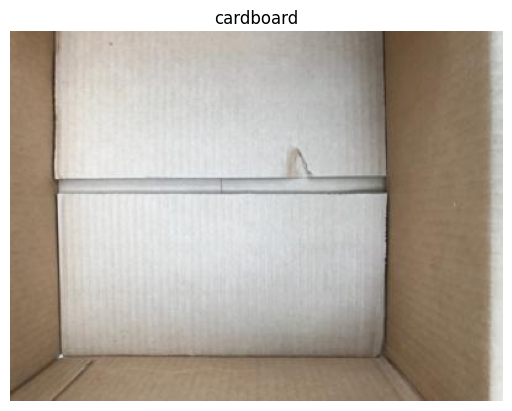

In [8]:
# Visualize same image using numpy
img_as_np = np.asarray(img)

print(f"Image height: {img_as_np.shape[0]}")
print(f"Image width: {img_as_np.shape[1]}")
print(f"Image shape: {img_as_np.shape}")
print(f"Image label: {label}")

plt.imshow(img_as_np)
plt.axis(False)
plt.title(label)

## **5.** Convert data -> Dataset -> DataLoader

In [9]:
# Define transforms for data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
# Create datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

# Create data loaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
len(test_loader), len(train_loader)

(18, 69)

In [13]:
# Get some constants
class_names = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

## **6.** Image and Dataset Inspection

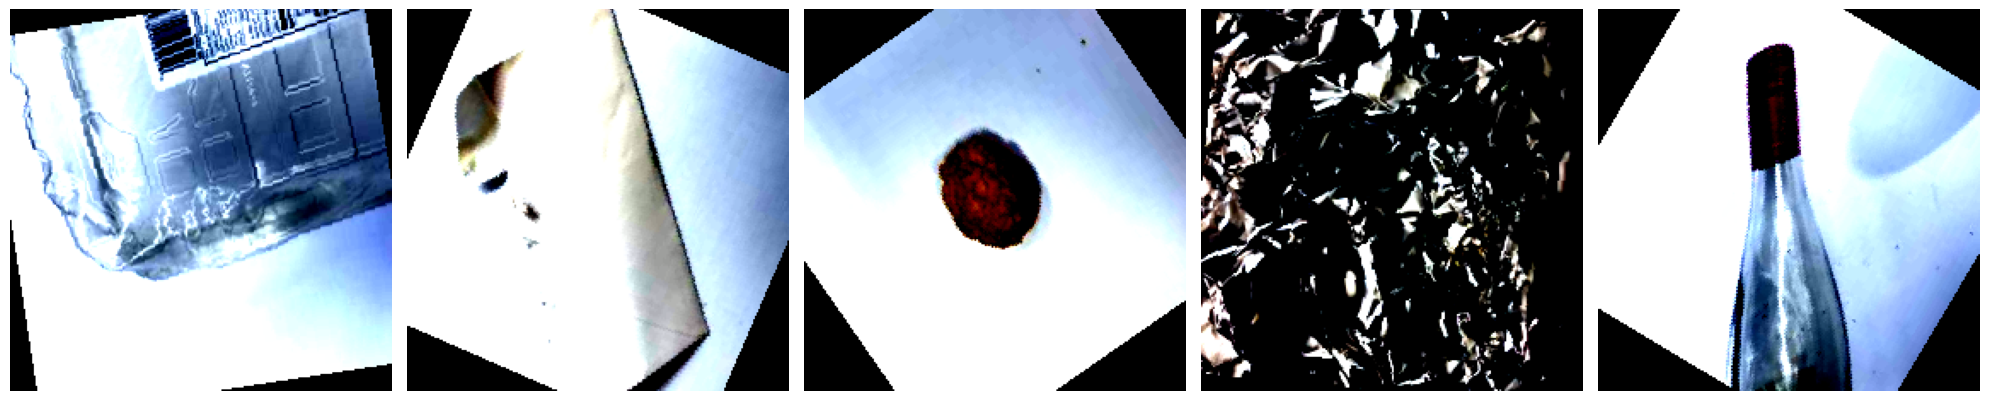

In [14]:
# Function to plot images
def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Show some augmented images
images = next(iter(train_loader))[0][:5]
plot_images(images)

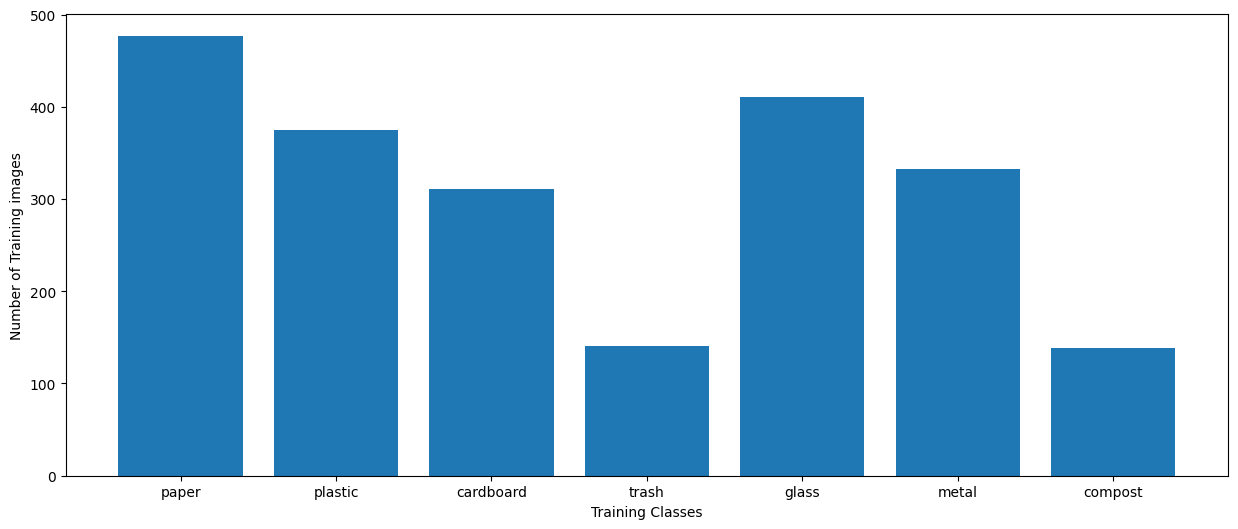

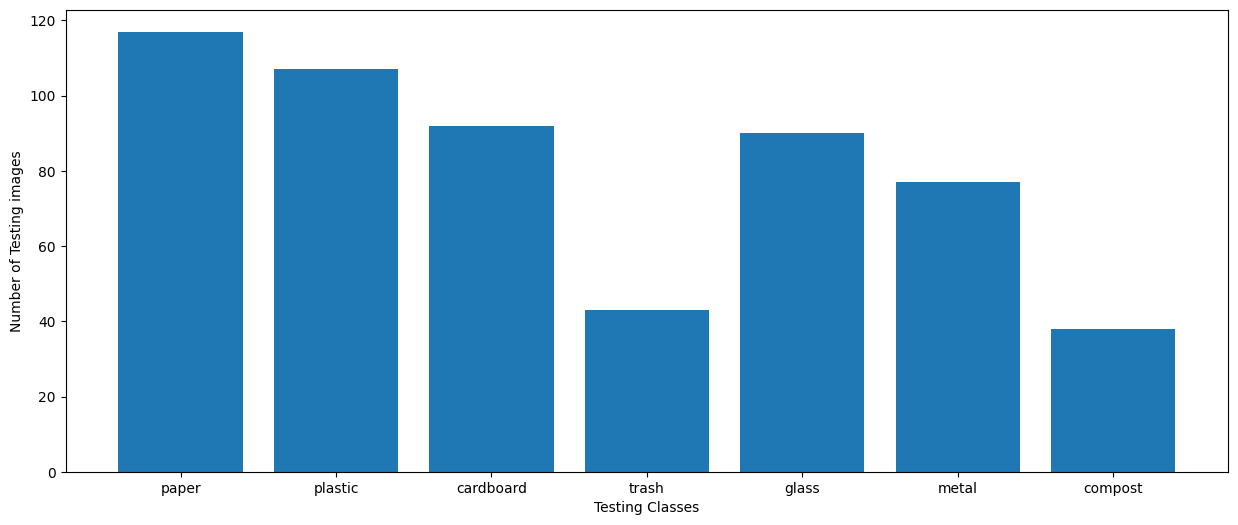

In [15]:
# Count number of images in each class
def count_images(data_dir):
    data_dict = {}
    for folder in os.listdir(data_dir):
        data_dict[folder] = len(os.listdir(os.path.join(data_dir, folder)))
    return data_dict

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

# Plot image counts
plt.figure(figsize=(15, 6))
plt.bar(train_counts.keys(), train_counts.values())
plt.xlabel('Training Classes')
plt.ylabel('Number of Training images')
plt.show()

plt.figure(figsize=(15, 6))
plt.bar(test_counts.keys(), test_counts.values())
plt.xlabel('Testing Classes')
plt.ylabel('Number of Testing images')
plt.show()

## **7.** Pre-Trained Model initialization and Transfer Learning

In [16]:
# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_classes = len(class_names)
model.classifier[6] = nn.Linear(4096, num_classes)

# Move model to GPU if available
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[6].parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 173MB/s]


In [17]:
# Define the class dictionary
"""class_dict = {
    'paper': 0,
    'plastic': 1,
    'cardboard': 2,
    'compost': 3,
    'trash': 4,
    'metal': 5,
    'glass': 6
}

# Training loop
num_epochs = 50
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
"""

"class_dict = {\n    'paper': 0,\n    'plastic': 1,\n    'cardboard': 2,\n    'compost': 3,\n    'trash': 4,\n    'metal': 5,\n    'glass': 6\n}\n\n# Training loop\nnum_epochs = 50\nbest_accuracy = 0.0\n\nfor epoch in range(num_epochs):\n    model.train()\n    running_loss = 0.0\n\n    for inputs, labels in tqdm(train_loader):\n        inputs, labels = inputs.to(device), labels.to(device)\n\n        optimizer.zero_grad()\n        outputs = model(inputs)\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n\n        running_loss += loss.item() * inputs.size(0)\n\n    epoch_loss = running_loss / len(train_loader.dataset)\n\n    # Validation\n    model.eval()\n    correct = 0\n    total = 0\n\n    with torch.no_grad():\n        for inputs, labels in test_loader:\n            inputs, labels = inputs.to(device), labels.to(device)\n            outputs = model(inputs)\n            _, predicted = torch.max(outputs.data, 1)\n            total += labels.

## **8.** Train the model

In [18]:
def train_step(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


In [19]:
def test_step(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [20]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=50):
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        epoch_loss = train_step(model, train_loader, criterion, optimizer, device)
        accuracy = test_step(model, test_loader, device)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, device)

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [1/50], Loss: 1.1690, Accuracy: 0.6472


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [2/50], Loss: 0.8851, Accuracy: 0.7057


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [3/50], Loss: 0.8199, Accuracy: 0.6950


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [4/50], Loss: 0.7937, Accuracy: 0.7429


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [5/50], Loss: 0.7973, Accuracy: 0.7624


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [6/50], Loss: 0.7507, Accuracy: 0.7340


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [7/50], Loss: 0.7647, Accuracy: 0.7447


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [8/50], Loss: 0.7581, Accuracy: 0.7411


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [9/50], Loss: 0.7334, Accuracy: 0.7660


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [10/50], Loss: 0.7210, Accuracy: 0.7571


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [11/50], Loss: 0.7726, Accuracy: 0.7872


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [12/50], Loss: 0.7468, Accuracy: 0.7730


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [13/50], Loss: 0.7347, Accuracy: 0.7606


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [14/50], Loss: 0.7514, Accuracy: 0.7766


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [15/50], Loss: 0.7327, Accuracy: 0.7784


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [16/50], Loss: 0.7268, Accuracy: 0.7819


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [17/50], Loss: 0.7140, Accuracy: 0.7855


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [18/50], Loss: 0.7095, Accuracy: 0.7908


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [19/50], Loss: 0.7188, Accuracy: 0.7890


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [20/50], Loss: 0.7347, Accuracy: 0.7996


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [21/50], Loss: 0.7269, Accuracy: 0.7961


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [22/50], Loss: 0.7006, Accuracy: 0.7837


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [23/50], Loss: 0.7144, Accuracy: 0.7908


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [24/50], Loss: 0.7161, Accuracy: 0.8032


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [25/50], Loss: 0.7066, Accuracy: 0.7855


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [26/50], Loss: 0.7073, Accuracy: 0.7837


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [27/50], Loss: 0.7100, Accuracy: 0.7730


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [28/50], Loss: 0.7066, Accuracy: 0.7801


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [29/50], Loss: 0.6888, Accuracy: 0.7943


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [30/50], Loss: 0.7330, Accuracy: 0.7837


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [31/50], Loss: 0.7293, Accuracy: 0.7926


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [32/50], Loss: 0.7509, Accuracy: 0.7730


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [33/50], Loss: 0.7196, Accuracy: 0.7801


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [34/50], Loss: 0.7068, Accuracy: 0.7695


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [35/50], Loss: 0.7479, Accuracy: 0.7855


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [36/50], Loss: 0.7050, Accuracy: 0.7908


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [37/50], Loss: 0.6755, Accuracy: 0.7801


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [38/50], Loss: 0.7230, Accuracy: 0.7766


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [39/50], Loss: 0.7144, Accuracy: 0.7908


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [40/50], Loss: 0.7278, Accuracy: 0.7695


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [41/50], Loss: 0.7288, Accuracy: 0.7766


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [42/50], Loss: 0.7398, Accuracy: 0.7908


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [43/50], Loss: 0.6963, Accuracy: 0.8014


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [44/50], Loss: 0.7193, Accuracy: 0.7908


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [45/50], Loss: 0.7596, Accuracy: 0.7677


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [46/50], Loss: 0.7040, Accuracy: 0.7801


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [47/50], Loss: 0.7199, Accuracy: 0.7713


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [48/50], Loss: 0.6987, Accuracy: 0.7784


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [49/50], Loss: 0.7527, Accuracy: 0.8067


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch [50/50], Loss: 0.7256, Accuracy: 0.7624


## **9.** Evaluate model performance

              precision    recall  f1-score   support

           0       0.94      0.87      0.90        92
           1       0.91      0.84      0.88        38
           2       0.79      0.80      0.80        90
           3       0.71      0.84      0.77        77
           4       0.85      0.85      0.85       117
           5       0.72      0.78      0.75       107
           6       0.80      0.56      0.66        43

    accuracy                           0.81       564
   macro avg       0.82      0.79      0.80       564
weighted avg       0.81      0.81      0.81       564

[[80  0  0  2  8  2  0]
 [ 0 32  0  3  1  1  1]
 [ 0  0 72  9  0  8  1]
 [ 0  1  7 65  1  3  0]
 [ 1  0  0  3 99 12  2]
 [ 0  0 12  7  3 83  2]
 [ 4  2  0  2  5  6 24]]


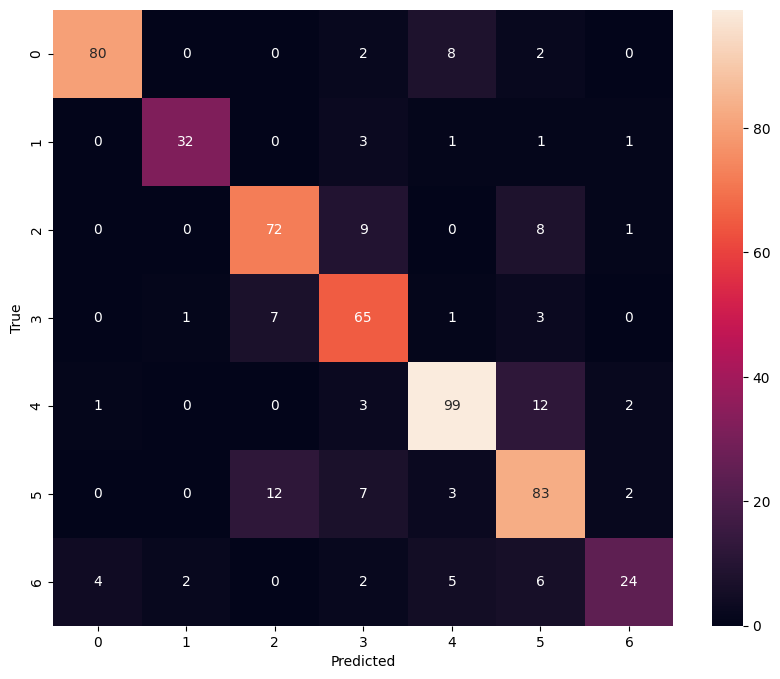

Test accuracy: 0.8067


In [21]:
# Evaluation
trained_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = trained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(all_labels, all_preds))
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

# Calculate and print accuracy
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f'Test accuracy: {accuracy:.4f}')